In [ ]:
from pathlib import Path
import os

DAY = "20251201"
Version = "v1"

PROJECT_ROOT = Path(os.getenv("LLMSC_ROOT", ".")).resolve()

DATA_DIR = Path(os.getenv("LLMSC_DATA_DIR", PROJECT_ROOT / "input")).resolve()
OUT_DIR  = Path(os.getenv("LLMSC_OUT_DIR",  PROJECT_ROOT / "runs" / f"{DAY}.{Version}")).resolve()
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [ ]:
RANDOM_SEED = 42
import random, os
import numpy as np
random.seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print(f"🔒 Random seed set to {RANDOM_SEED} for reproducibility.")

🔒 Random seed set to 42 for reproducibility.


In [ ]:
import celltypist
from celltypist import models

import scanpy as sc

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import json
import gc
import time
import scipy

import warnings
warnings.filterwarnings("ignore")

In [ ]:
%%capture
%load_ext rpy2.ipython

In [ ]:
%R -i PROJECT_ROOT -i DATA_DIR -i OUT_DIR -i DAY -i Version

In [ ]:
DATASETS = {
    "cd8": {
        "adata_path": f"{OUT_DIR}/cd8_benchmark_data.h5ad",
        "benchmark_csv": f"{OUT_DIR}/cd8_benchmark_results.csv",
        "cluster_col": "meta.cluster",
        "celltypist_model_name": "Immune_All_Low.pkl",
    },
    "cd4": {
        "adata_path": f"{OUT_DIR}/cd4_benchmark_data.h5ad",
        "benchmark_csv": f"{OUT_DIR}/cd4_benchmark_results.csv",
        "cluster_col": "meta.cluster",
        "celltypist_model_name": "Immune_All_Low.pkl",
    },
    "msc": {
        "adata_path": f"{OUT_DIR}/baca_msc_benchmark_data.h5ad",
        "benchmark_csv": f"{OUT_DIR}/msc_benchmark_results.csv",
        "cluster_col": "meta.cluster",
        "celltypist_model_name": "Human_Lung_Atlas.pkl",
    },
    "mouse_b": {
        "adata_path": f"{OUT_DIR}/mouse_b_benchmark_data.h5ad",
        "benchmark_csv": f"{OUT_DIR}/mouse_b_benchmark_results.csv",
        "cluster_col": "meta.cluster",
        "celltypist_model_name": None,
    },
}


In [ ]:
cd8_h5ad = DATASETS["cd8"]["adata_path"]
cd4_h5ad = DATASETS["cd4"]["adata_path"]
msc_h5ad = DATASETS["msc"]["adata_path"]
mouse_b_5ad = DATASETS["mouse_b"]["adata_path"]

In [ ]:
%R -i cd8_h5ad -i cd4_h5ad -i msc_h5ad -i mouse_b_5ad

In [ ]:
%%R
library(scater)
library(SingleR)
library(Azimuth)
library(celldex)
library(anndataR)
library(data.table)
library(Seurat)
library(SeuratObject)



    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

Loading required package: SingleCellExperiment
Loading required package: SummarizedExperiment
Loading required package: MatrixGenerics
Loading required package: matrixStats

Attaching package: ‘MatrixGenerics’

The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOr

In [ ]:
%%R
# ==========================================
# R function to run SingleR + (optional) Azimuth
# ==========================================
library(future)
plan(sequential)

annotate_with_SingleR_Azimuth <- function(
  in_h5ad,
  OUT_DIR,
  day,
  version,
  dataset_tag = "",
  celldex_ref = celldex::MonacoImmuneData(),
  azimuth_ref_path = ""
) {
  message("📂 Loading h5ad: ", in_h5ad)
  sce <- anndataR::read_h5ad(in_h5ad, as = "SingleCellExperiment")

  # -------------------------------
  # SingleR
  # -------------------------------
  ref <- celldex_ref
  message("⚙️ Running SingleR with reference: ", class(ref)[1])
  pred_sr <- SingleR::SingleR(test = sce, ref = ref, labels = ref$label.fine)

  # -------------------------------
  # Azimuth (skip for mouse_b)
  # -------------------------------
  run_azimuth <- !identical(dataset_tag, "mouse_b")

  if (run_azimuth) {
    message("⚙️ Running Azimuth...")
    sce.seurat <- Seurat::as.Seurat(sce, counts = "counts", data = "logcounts")
    sce.seurat <- Azimuth::RunAzimuth(query = sce.seurat, reference = azimuth_ref_path)

    meta <- sce.seurat@meta.data
    az_cols <- colnames(meta)

    cand <- c(
      "predicted.celltype.l2",
      "predicted.ann_level_2",
      "predicted.annotation.l2"
    )
    found <- cand[cand %in% az_cols]

    if (length(found) == 0) {
      stop(
        "Azimuth label column not found. Available columns: ",
        paste(az_cols, collapse = ", ")
      )
    } else {
      use_col <- found[1]
      message("🔎 Using Azimuth label column: ", use_col)
      azimuth_pred <- meta[[use_col]]
    }

  } else {
    message("⏭️ Skipping Azimuth for dataset_tag: ", dataset_tag)
    azimuth_pred <- rep(NA_character_, length(colnames(sce)))
  }

  # -------------------------------
  # Assemble results & write file
  # -------------------------------
  results <- data.frame(
    Barcode      = colnames(sce),
    SingleR_Pred = pred_sr$labels,
    Azimuth_Pred = azimuth_pred,
    stringsAsFactors = FALSE
  )

  out_f <- file.path(
    OUT_DIR,
    sprintf("%s_singler_Azimuth_predictions.%s.%s.csv.gz", day, dataset_tag, version)
  )

  message("📝 Will write to: ", out_f)
  data.table::fwrite(results, out_f)
  message("✅ Predictions saved to: ", out_f)
  message("👀 file.exists(out_f): ", file.exists(out_f))

  invisible(out_f)
}


In [ ]:
%%R
# ==========================================
# R cells for each dataset
# ==========================================

# CD8
annotate_with_SingleR_Azimuth(
  in_h5ad     = cd8_h5ad,
  OUT_DIR      = OUT_DIR,
  day         = DAY,
  version     = Version,
  dataset_tag = "cd8",
  celldex_ref = celldex::MonacoImmuneData(),
  azimuth_ref_path = file.path(PROJECT_ROOT, "input/Azimuth_Reference/Human_PBMC")
)

  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=02s  


📂 Loading h5ad:/runs/20251201.v1/cd8_benchmark_data.h5ad
Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'
Also defined by 'alabaster.base'
⚙️ Running SingleR with reference: SummarizedExperiment
⚙️ Running Azimuth...
Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'
Also defined by 'alabaster.base'
Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'
Also defined by 'alabaster.base'
Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'
Also defined by 'alabaster.base'
Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'
Also defined by 'alabaster.base'
detected inputs from HUMAN with id type Gene.name
reference rownames detected HUMAN with id type Gene.name
Normalizing query using reference SCT model
Continuing with remaining 4245 features.
Onl

In [ ]:
%%R
# CD4
annotate_with_SingleR_Azimuth(
  in_h5ad     = cd4_h5ad,
  OUT_DIR      = OUT_DIR,
  day         = DAY,
  version     = Version,
  dataset_tag = "cd4",
  celldex_ref = celldex::MonacoImmuneData(),
  azimuth_ref_path = file.path(PROJECT_ROOT, "input/Azimuth_Reference/Human_PBMC")
)

  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=00s  


📂 Loading h5ad: /runs/20251201.v1/cd4_benchmark_data.h5ad
Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'
Also defined by 'alabaster.base'
⚙️ Running SingleR with reference: SummarizedExperiment
⚙️ Running Azimuth...
Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'
Also defined by 'alabaster.base'
Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'
Also defined by 'alabaster.base'
Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'
Also defined by 'alabaster.base'
Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'
Also defined by 'alabaster.base'
detected inputs from HUMAN with id type Gene.name
reference rownames detected HUMAN with id type Gene.name
Normalizing query using reference SCT model
Continuing with remaining 4245 features.
On

In [ ]:
%%R
# BRCA MSC
options(future.globals.maxSize = 8 * 1024^3)

annotate_with_SingleR_Azimuth(
  in_h5ad     = msc_h5ad,
  OUT_DIR      = OUT_DIR,
  day         = DAY,
  version     = Version,
  dataset_tag = "msc",
  celldex_ref = celldex::BlueprintEncodeData(),
  azimuth_ref_path = file.path(PROJECT_ROOT, "input/Azimuth_Reference/Human_Lung")
)

  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=13s  


📂 Loading h5ad: /runs/20251201.v1/baca_msc_benchmark_data.h5ad
Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'
Also defined by 'alabaster.base'
⚙️ Running SingleR with reference: SummarizedExperiment
⚙️ Running Azimuth...
Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'
Also defined by 'alabaster.base'
Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'
Also defined by 'alabaster.base'
Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'
Also defined by 'alabaster.base'
Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'
Also defined by 'alabaster.base'
detected inputs from HUMAN with id type Gene.name
reference rownames detected HUMAN with id type Gene.name
Normalizing query using reference SCT model
Continuing with remaining 2992 feature

In [ ]:
%%R
# Mouse
annotate_with_SingleR_Azimuth(
  in_h5ad     = mouse_b_5ad,
  OUT_DIR      = OUT_DIR,
  day         = DAY,
  version     = Version,
  dataset_tag = "mouse_b",
  celldex_ref = celldex::ImmGenData(),
)

📂 Loading h5ad: /runs/20251201.v1/mouse_b_benchmark_data.h5ad
Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'
Also defined by 'alabaster.base'
⚙️ Running SingleR with reference: SummarizedExperiment
⏭️ Skipping Azimuth for dataset_tag: mouse_b
📝 Will write to: /runs/20251201.v1/20251201_singler_Azimuth_predictions.mouse_b.v1.csv.gz
✅ Predictions saved to: /runs/20251201.v1/20251201_singler_Azimuth_predictions.mouse_b.v1.csv.gz
👀 file.exists(out_f): TRUE


In [ ]:
def integrate_annotations(
    dataset_tag: str,
    adata_path: str,
    benchmark_csv_path: str,
    OUT_DIR: str,
    day: str,
    version: str,
    cluster_col: str = "meta.cluster",
    celltypist_model_name=None,
):
    """
    1) Load SingleR + Azimuth predictions (R-side output)
    2) Run CellTypist (if model name is given)
    3) Do majority vote per cluster
    4) Join with existing benchmark (Standard / Curator)
    5) Save CSV + JSON
    """

    # 1. Load R-side predictions
    pred_path = f"{OUT_DIR}/{day}_singler_Azimuth_predictions.{dataset_tag}.{version}.csv.gz"
    print(f"🔄 Loading SingleR/Azimuth predictions: {pred_path}")
    df_r = pd.read_csv(pred_path, index_col="Barcode")

    # 2. Load AnnData
    print(f"\n📂 Loading AnnData: {adata_path}")
    adata = sc.read_h5ad(adata_path)
    if cluster_col not in adata.obs.columns:
        raise ValueError(f"cluster_col '{cluster_col}' not found in adata.obs")

    print("\nCell counts per cluster:")
    print(adata.obs[cluster_col].value_counts().head(10))

    # 3. CellTypist (supervised baseline, optional)
    if celltypist_model_name is not None:
        print(f"\n🚀 Running CellTypist (supervised baseline): {celltypist_model_name}")
        celltypist.models.download_models(
            force_update=False,
            model=[celltypist_model_name],
        )
        predictions = celltypist.annotate(
            adata,
            model=celltypist_model_name,
            majority_voting=True,
        )
        adata.obs["CellTypist_Pred"] = predictions.predicted_labels["predicted_labels"]
        print("✅ CellTypist annotation complete.")
    else:
        print("\n⏭️ Skipping CellTypist (celltypist_model_name=None)")

        adata.obs["CellTypist_Pred"] = "Unknown"

    # 4. Join cell-level R predictions and CellTypist
    adata_obs = adata.obs[[cluster_col, "CellTypist_Pred"]].copy()
    del adata
    gc.collect()

    merged_df = adata_obs.join(df_r, how="left")

    # 5. Majority vote per cluster
    print("\n🗳️ Calculating majority votes per cluster...")

    def get_mode(x):
        m = x.mode()
        return m.iloc[0] if len(m) > 0 else "Unknown"

    cluster_votes = merged_df.groupby(cluster_col).agg(
        {
            "SingleR_Pred": get_mode,
            "Azimuth_Pred": get_mode,
            "CellTypist_Pred": get_mode,
        }
    )
    cluster_votes.columns = [
        "SingleR_Answer",
        "Azimuth_Answer",
        "CellTypist_Answer",
    ]

    # 6. Load existing benchmark (Standard / Curator)
    print(f"\n📊 Loading benchmark: {benchmark_csv_path}")
    bench_df = pd.read_csv(benchmark_csv_path)

    if "Cluster_ID" in bench_df.columns:
        bench_df = bench_df.set_index("Cluster_ID")

    # 7. Join on cluster ID
    final_df = bench_df.join(cluster_votes, how="left")
    final_df = final_df.reset_index().rename(columns={"index": "Cluster_ID"})

    # 8. Save CSV
    csv_save_path = f"{OUT_DIR}/{dataset_tag}_benchmark_results_integrated.csv"
    final_df.to_csv(csv_save_path, index=False)

    # 9. Save JSON
    required_cols = [
        "SingleR_Answer",
        "Azimuth_Answer",
        "Standard_Answer",
        "Curated_Answer",
    ]
    missing = [c for c in required_cols if c not in final_df.columns]
    if missing:
        raise ValueError(f"Missing columns in benchmark for JSON export: {missing}")

    result_dict = (
        final_df.set_index("Cluster_ID")[required_cols]
        .to_dict(orient="index")
    )

    json_save_path = f"{OUT_DIR}/{dataset_tag}_benchmark_results_integrated.json"
    with open(json_save_path, "w") as f:
        json.dump(result_dict, f, indent=4)

    # 10. Show head
    print("\n--- Integrated data sample ---")
    print(
        final_df[
            ["Cluster_ID", "SingleR_Answer", "Azimuth_Answer", "CellTypist_Answer"]
        ].head()
    )

    print(f"\n✅ Saved CSV : {csv_save_path}")
    print(f"✅ Saved JSON: {json_save_path}")

    return final_df, result_dict

In [ ]:
# ==========================================
# Python : dataset configuration & calls
# ==========================================

for tag, cfg in DATASETS.items():
    print(f"\n================ {tag.upper()} ================")
    integrate_annotations(
        dataset_tag=tag,
        adata_path=cfg["adata_path"],
        benchmark_csv_path=cfg["benchmark_csv"],
        OUT_DIR=OUT_DIR,
        day=DAY,
        version=Version,
        cluster_col=cfg["cluster_col"],
        celltypist_model_name=cfg["celltypist_model_name"],
    )



================ CD8 ================
🔄 Loading SingleR/Azimuth predictions: /runs/20251201.v1/content20251210_singler_Azimuth_predictions.cd8.v4_5R.csv.gz

📂 Loading AnnData:/runs/20251201.v1/cd8_benchmark_data.h5ad

Cell counts per cluster:
meta.cluster
CD8.c01.Tn.MAL          300
CD8.c02.Tm.IL7R         300
CD8.c03.Tm.RPS12        300
CD8.c04.Tm.CD52         300
CD8.c05.Tem.CXCR5       300
CD8.c06.Tem.GZMK        300
CD8.c07.Temra.CX3CR1    300
CD8.c11.Tex.PDCD1       300
CD8.c10.Trm.ZNF683      300
CD8.c12.Tex.CXCL13      300
Name: count, dtype: int64

🚀 Running CellTypist (supervised baseline): Immune_All_Low.pkl
✅ CellTypist annotation complete.

🗳️ Calculating majority votes per cluster...

📊 Loading benchmark: /runs/20251201.v1/cd8_benchmark_results.csv

--- Integrated data sample ---
          Cluster_ID               SingleR_Answer Azimuth_Answer  \
0     CD8.c01.Tn.MAL   Central memory CD8 T cells        CD8 TCM   
1    CD8.c02.Tm.IL7R  Effector memory CD8 T cells        CD

In [ ]:
%cd /input/LLM-scCurator

!python3 -m benchmarks.evaluate_all --data_dir $OUT_DIR --out_dir $OUT_DIR


/input/LLM-scCurator

[INFO] Processing CD8 from /runs/20251201.v1/cd8_benchmark_results_integrated.csv...
  > Applying GT mapper (get_cd8_ground_truth) using column 'Cluster_ID'
  > Standard       : Mean=0.753, Frac==1=0.588, Frac>=0.5=0.824
  > Curated        : Mean=0.818, Frac==1=0.529, Frac>=0.5=0.941
  > CellTypist     : Mean=0.735, Frac==1=0.118, Frac>=0.5=1.000
  > SingleR        : Mean=0.859, Frac==1=0.529, Frac>=0.5=1.000
  > Azimuth        : Mean=0.835, Frac==1=0.588, Frac>=0.5=0.941
[INFO] Saved detailed scores → /runs/20251201.v1/cd8_benchmark_results_integrated_SCORED.csv
[INFO] CD8/Standard: confusion → /runs/20251201.v1/CD8_confusion_Standard.csv
[INFO] CD8/Standard: per-state metrics → /runs/20251201.v1/CD8_per_state_metrics_Standard.csv
[INFO] CD8/Curated: confusion → /runs/20251201.v1/CD8_confusion_Curated.csv
[INFO] CD8/Curated: per-state metrics → /runs/20251201.v1/CD8_per_state_metrics_Curated.csv

[INFO] Processing CD4 from /runs/20251201.v1/cd4_benchmark_results_

In [ ]:
!ls /LLM-scCurator/benchmarks/

caf_config.py  evaluate_all.py		__init__.py	   scorer_caf.py
cd4_config.py  gt_mappings.py		mouse_b_config.py
cd8_config.py  hierarchical_scoring.py	__pycache__


In [ ]:
# ==========================================
# Load the 4 *_SCORED.csv files
# Calculate the average score and 95% CI for each Dataset × Pipeline
# ==========================================

DATASETS = {
    "CD8":     "cd8_benchmark_results_integrated_SCORED.csv",
    "CD4":     "cd4_benchmark_results_integrated_SCORED.csv",
    "MSC":     "msc_benchmark_results_integrated_SCORED.csv",
    "MOUSE_B": "mouse_b_benchmark_results_integrated_SCORED.csv",
}

PIPELINE_ORDER = ["Standard", "CellTypist", "SingleR", "Azimuth", "Curated"]

PIPELINE_LABELS = {
    "Standard":   "Standard\n(Top DE)",
    "CellTypist": "CellTypist\n(Supervised)",
    "SingleR":    "SingleR\n(Reference)",
    "Azimuth":    "Azimuth\n(Reference)",
    "Curated":    "LLM-scCurator\n(Feature distillation)",
}

def compute_mean_and_ci(scores: pd.Series, z: float = 1.96):
    """
    scores: Vector of scores ranging from 0 to 1
    Calculate 95% CI using normal approximation (mean ± z * SE)
    """
    scores = scores.dropna().astype(float)
    n = len(scores)
    if n == 0:
        return np.nan, np.nan, np.nan, 0

    mean = scores.mean()
    if n > 1:
        se = scores.std(ddof=1) / np.sqrt(n)
        margin = z * se
    else:
        margin = 0.0

    low = max(0.0, mean - margin)
    high = min(1.0, mean + margin)
    return mean, low, high, n

rows = []

for dataset, filename in DATASETS.items():
    csv_path = os.path.join(OUT_DIR, filename)
    if not os.path.exists(csv_path):
        print(f"[WARN] not found: {csv_path}")
        continue

    df = pd.read_csv(csv_path)

    for pipeline in PIPELINE_ORDER:
        score_col = f"Score_{pipeline}"
        if score_col not in df.columns:
            continue

        mean, low, high, n = compute_mean_and_ci(df[score_col])
        rows.append({
            "Dataset": dataset,
            "Pipeline": pipeline,
            "N": n,
            "Mean": mean,
            "CI_Low": low,
            "CI_High": high,
        })

summary_df = pd.DataFrame(rows)
summary_df["Mean_pct"]   = summary_df["Mean"]    * 100.0
summary_df["CI_Low_pct"] = summary_df["CI_Low"]  * 100.0
summary_df["CI_High_pct"]= summary_df["CI_High"] * 100.0

print(summary_df)

summary_csv_path = os.path.join(OUT_DIR, "Fig2a_Benchmark_4Datasets_Bars.csv")
summary_df.to_csv(summary_csv_path, index=False)
print(f"[INFO] Saved summary for plotting → {summary_csv_path}")


    Dataset    Pipeline   N      Mean    CI_Low   CI_High    Mean_pct  \
0       CD8    Standard  17  0.752941  0.571834  0.934048   75.294118   
1       CD8  CellTypist  17  0.735294  0.687932  0.782656   73.529412   
2       CD8     SingleR  17  0.858824  0.785451  0.932196   85.882353   
3       CD8     Azimuth  17  0.835294  0.711857  0.958732   83.529412   
4       CD8     Curated  17  0.817647  0.695020  0.940274   81.764706   
5       CD4    Standard  22  0.750000  0.601418  0.898582   75.000000   
6       CD4  CellTypist  22  0.863636  0.799746  0.927527   86.363636   
7       CD4     SingleR  22  0.604545  0.486018  0.723073   60.454545   
8       CD4     Azimuth  22  0.863636  0.799746  0.927527   86.363636   
9       CD4     Curated  22  0.850000  0.785844  0.914156   85.000000   
10      MSC    Standard   8  0.806250  0.586773  1.000000   80.625000   
11      MSC  CellTypist   8  0.825000  0.600454  1.000000   82.500000   
12      MSC     SingleR   8  0.243750  0.189954  0.

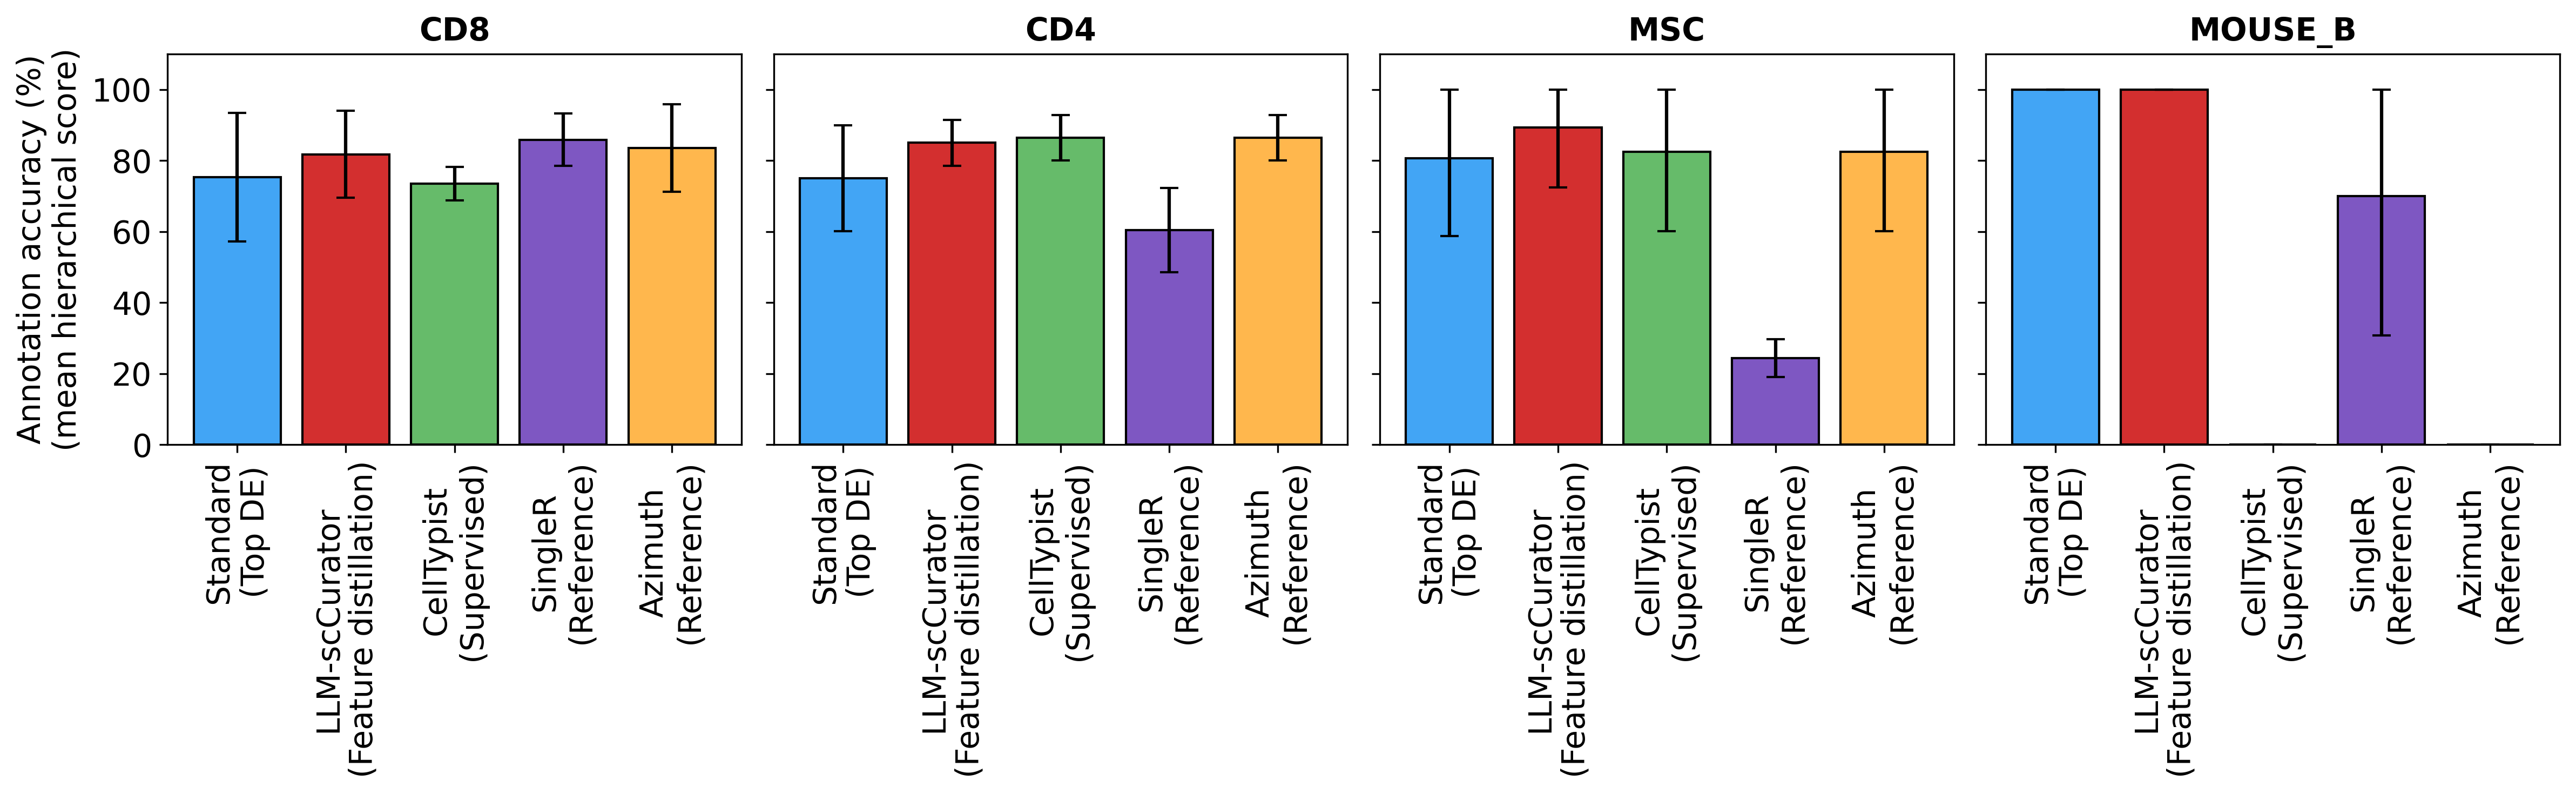

[INFO] Saved bar figure → /runs/20251201.v1/Fig2a_Benchmark_4Datasets_Bars.pdf


In [ ]:
PIPELINE_COLORS = {
    "Standard":   "#42A5F5",  # Blues
    "Curated":    "#D32F2F",  # Reds
    "CellTypist": "#66BB6A",  # Greens
    "SingleR":    "#7E57C2",  # Purple
    "Azimuth":    "#FFB74D",  # Orange
}

# Sort order
PIPELINE_ORDER = ["Standard", "Curated", "CellTypist", "SingleR", "Azimuth"]
DATASET_ORDER = ["CD8", "CD4", "MSC", "MOUSE_B"]

fig, axes = plt.subplots(1, 4, figsize=(16, 5), dpi=300, sharey=True)

for ax, dataset in zip(axes, DATASET_ORDER):
    sub = summary_df[summary_df["Dataset"] == dataset].copy()
    if sub.empty:
        ax.axis("off")
        continue

    pipelines_present = [p for p in PIPELINE_ORDER if p in sub["Pipeline"].values]
    sub = sub.set_index("Pipeline").loc[pipelines_present].reset_index()

    x = np.arange(len(sub))
    means = sub["Mean_pct"].values
    ci_low = sub["CI_Low_pct"].values
    ci_high = sub["CI_High_pct"].values
    yerr = np.vstack([means - ci_low, ci_high - means])

    colors = [PIPELINE_COLORS[p] for p in sub["Pipeline"]]
    bars = ax.bar(
        x,
        means,
        yerr=yerr,
        capsize=4,
        color=colors,
        edgecolor="black",
        linewidth=1.0,
    )

    ax.set_xticks(x)
    ax.set_xticklabels(
        [PIPELINE_LABELS[p] for p in sub["Pipeline"]],
        rotation=90,
        fontsize=14,
    )
    ax.set_ylim(0, 110)

    ax.set_title(dataset, fontsize=14, fontweight="bold")

axes[0].set_ylabel("Annotation accuracy (%)\n(mean hierarchical score)", fontsize=14)
axes[0].tick_params(axis='y', labelsize=14)

plt.tight_layout()
fig_path_pdf = os.path.join(OUT_DIR, "Fig2a_Benchmark_4Datasets_Bars.pdf")
fig_path_png = os.path.join(OUT_DIR, "Fig2a_Benchmark_4Datasets_Bars.png")
plt.savefig(fig_path_pdf)
plt.savefig(fig_path_png, dpi=300)
plt.show()

print(f"[INFO] Saved bar figure → {fig_path_pdf}")


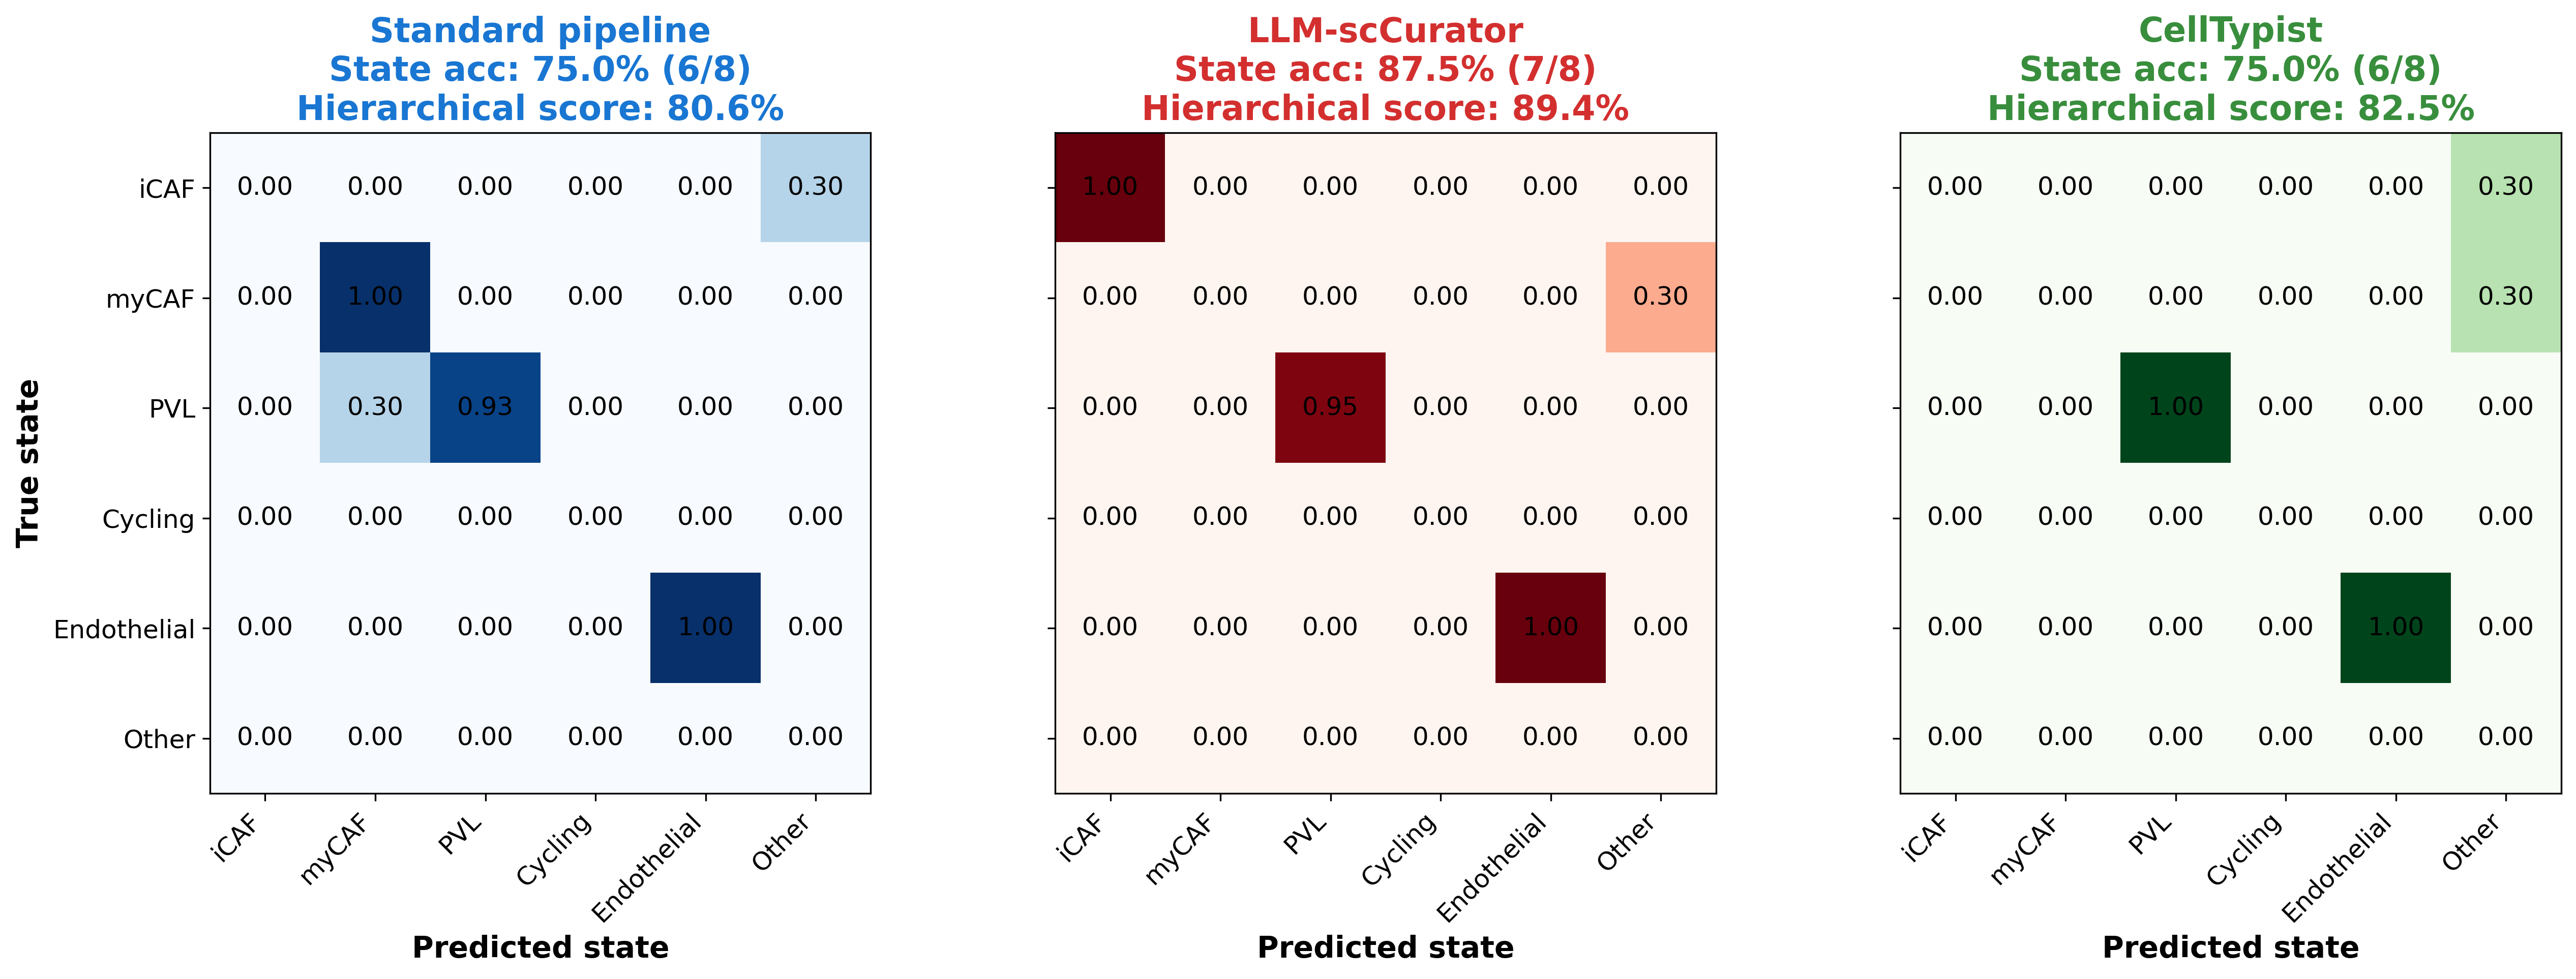

[INFO] Saved MSC confusion figure → /runs/20251201.v1/Figure2_MSC_Confusion_Standard_Curated_CellTypist.pdf


In [ ]:
REPO_ROOT = os.path.join(PROJECT_ROOT, "input", "LLM-scCurator")
sys.path.append(REPO_ROOT)

from benchmarks.hierarchical_scoring import _parse_state_generic
from benchmarks.caf_config import CAF_HIER_CFG

MSC_SCORED = os.path.join(OUT_DIR, "msc_benchmark_results_integrated_SCORED.csv")

# colormap and title colors are shared with CD8/CD4/MOUSE_B figures
PIPELINE_CMAPS = {
    "Standard":   "Blues",
    "Curated":    "Reds",
    "CellTypist": "Greens",
}

PIPELINE_TITLE_COLORS = {
    "Standard":   "#1976D2",  # blue
    "Curated":    "#D32F2F",  # red
    "CellTypist": "#388E3C",  # green
}


def choose_prediction_column(df: pd.DataFrame, pipeline: str) -> str:
    """Return the column name that contains textual predictions."""
    method_name = f"{pipeline}_Answer"
    if method_name in df.columns:
        return method_name

    subtype_col = method_name.replace("Answer", "Subtype_Clean")
    if subtype_col in df.columns:
        return subtype_col

    raise ValueError(f"No prediction column found for pipeline={pipeline}")


def compute_msc_confusion(df: pd.DataFrame, pipeline: str):
    """
    MSC dataset:
      - Build a 6x6 matrix (iCAF/myCAF/PVL/Cycling/Endothelial/Other).
      - Each cell holds the *mean hierarchical score* (0–1) for
        (GT_State, Predicted state) pairs for the given pipeline.
      - Also return plain state accuracy and global mean hierarchical score.
    """
    pred_col = choose_prediction_column(df, pipeline)
    score_col = f"Score_{pipeline}"
    if score_col not in df.columns:
        raise ValueError(f"{score_col} not found in dataframe.")

    # Use only rows with a non-default GT_State
    df_used = df[df["GT_State"] != CAF_HIER_CFG.default_state].copy()

    gt_states = []
    pred_states = []

    # fixed label order so that axes are perfectly aligned across panels
    state_order = ["iCAF", "myCAF", "PVL", "Cycling", "Endothelial", "Other"]
    labels = state_order[:]  # always 6 labels

    label_to_idx = {lab: i for i, lab in enumerate(labels)}
    # cm_sum accumulates hierarchical scores; cm_count counts entries per cell
    cm_sum = np.zeros((len(labels), len(labels)), dtype=float)
    cm_count = np.zeros((len(labels), len(labels)), dtype=int)

    for _, row in df_used.iterrows():
        gt = str(row["GT_State"])
        pred = _parse_state_generic(str(row[pred_col]), CAF_HIER_CFG)
        score = float(row[score_col])

        gt_lab = gt if gt in label_to_idx else "Other"
        pred_lab = pred if pred in label_to_idx else "Other"

        i = label_to_idx[gt_lab]
        j = label_to_idx[pred_lab]

        cm_sum[i, j] += score
        cm_count[i, j] += 1

        gt_states.append(gt_lab)
        pred_states.append(pred_lab)

    # mean hierarchical score per cell (0–1)
    with np.errstate(invalid="ignore", divide="ignore"):
        cm_mean = np.where(cm_count > 0, cm_sum / cm_count, 0.0)

    # plain state accuracy (exact state match, 0/1)
    n = len(gt_states)
    n_correct = sum(1 for g, p in zip(gt_states, pred_states) if g == p)
    state_acc = 100.0 * n_correct / n if n > 0 else 0.0

    # global mean hierarchical score (%)
    hier_mean = df_used[score_col].dropna().astype(float).mean() * 100.0

    return {
        "labels": labels,
        "cm_norm": cm_mean,  # now: mean hierarchical score, not row-normalized freq
        "state_acc": state_acc,
        "n_correct": n_correct,
        "n": n,
        "hier_mean": hier_mean,
    }


def plot_msc_confusion(scored_csv: str, out_pdf: str, out_png: str = None):
    df = pd.read_csv(scored_csv)

    # Order: Standard and Curated side-by-side, then CellTypist
    pipelines = ["Standard", "Curated", "CellTypist"]
    titles = {
        "Standard":   "Standard pipeline",
        "Curated":    "LLM-scCurator",
        "CellTypist": "CellTypist",
    }

    results = {p: compute_msc_confusion(df, p) for p in pipelines}

    # make the figure a bit larger to keep labels readable
    fig, axes = plt.subplots(1, len(pipelines), figsize=(18, 6), dpi=300)

    for ax, pipeline in zip(axes, pipelines):
        res = results[pipeline]
        labels = res["labels"]
        cm = res["cm_norm"]  # mean hierarchical score (0–1)

        im = ax.imshow(
            cm,
            vmin=0.0,
            vmax=1.0,
            cmap=PIPELINE_CMAPS[pipeline],
        )

        ax.set_xticks(np.arange(len(labels)))
        ax.set_yticks(np.arange(len(labels)))
        ax.set_xticklabels(labels, rotation=45, ha="right", fontsize=12)
        ax.set_yticklabels(labels, fontsize=12)

        # numeric values in each cell
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                val = cm[i, j]
                ax.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=12)

        title = (
            f"{titles[pipeline]}\n"
            f"State acc: {res['state_acc']:.1f}% "
            f"({res['n_correct']}/{res['n']})\n"
            f"Hierarchical score: {res['hier_mean']:.1f}%"
        )
        ax.set_title(
            title,
            fontsize=16,
            fontweight="bold",
            color=PIPELINE_TITLE_COLORS[pipeline],
        )

        if ax is axes[0]:
            ax.set_ylabel("True state", fontsize=14, fontweight="bold")
        else:
            ax.set_yticklabels([])

        ax.set_xlabel("Predicted state", fontsize=14, fontweight="bold")

    # Colorbar is omitted because colormaps differ across panels.
    plt.tight_layout()
    plt.savefig(out_pdf)
    if out_png is not None:
        plt.savefig(out_png, dpi=300)
    plt.show()

    print(f"[INFO] Saved MSC confusion figure → {out_pdf}")


# run
msc_conf_pdf = os.path.join(OUT_DIR, "EDFig2c_MSC_Confusion_Standard_Curated_CellTypist.pdf")
msc_conf_png = os.path.join(OUT_DIR, "EDFig2c_MSC_Confusion_Standard_Curated_CellTypist.png")

plot_msc_confusion(MSC_SCORED, msc_conf_pdf, msc_conf_png)


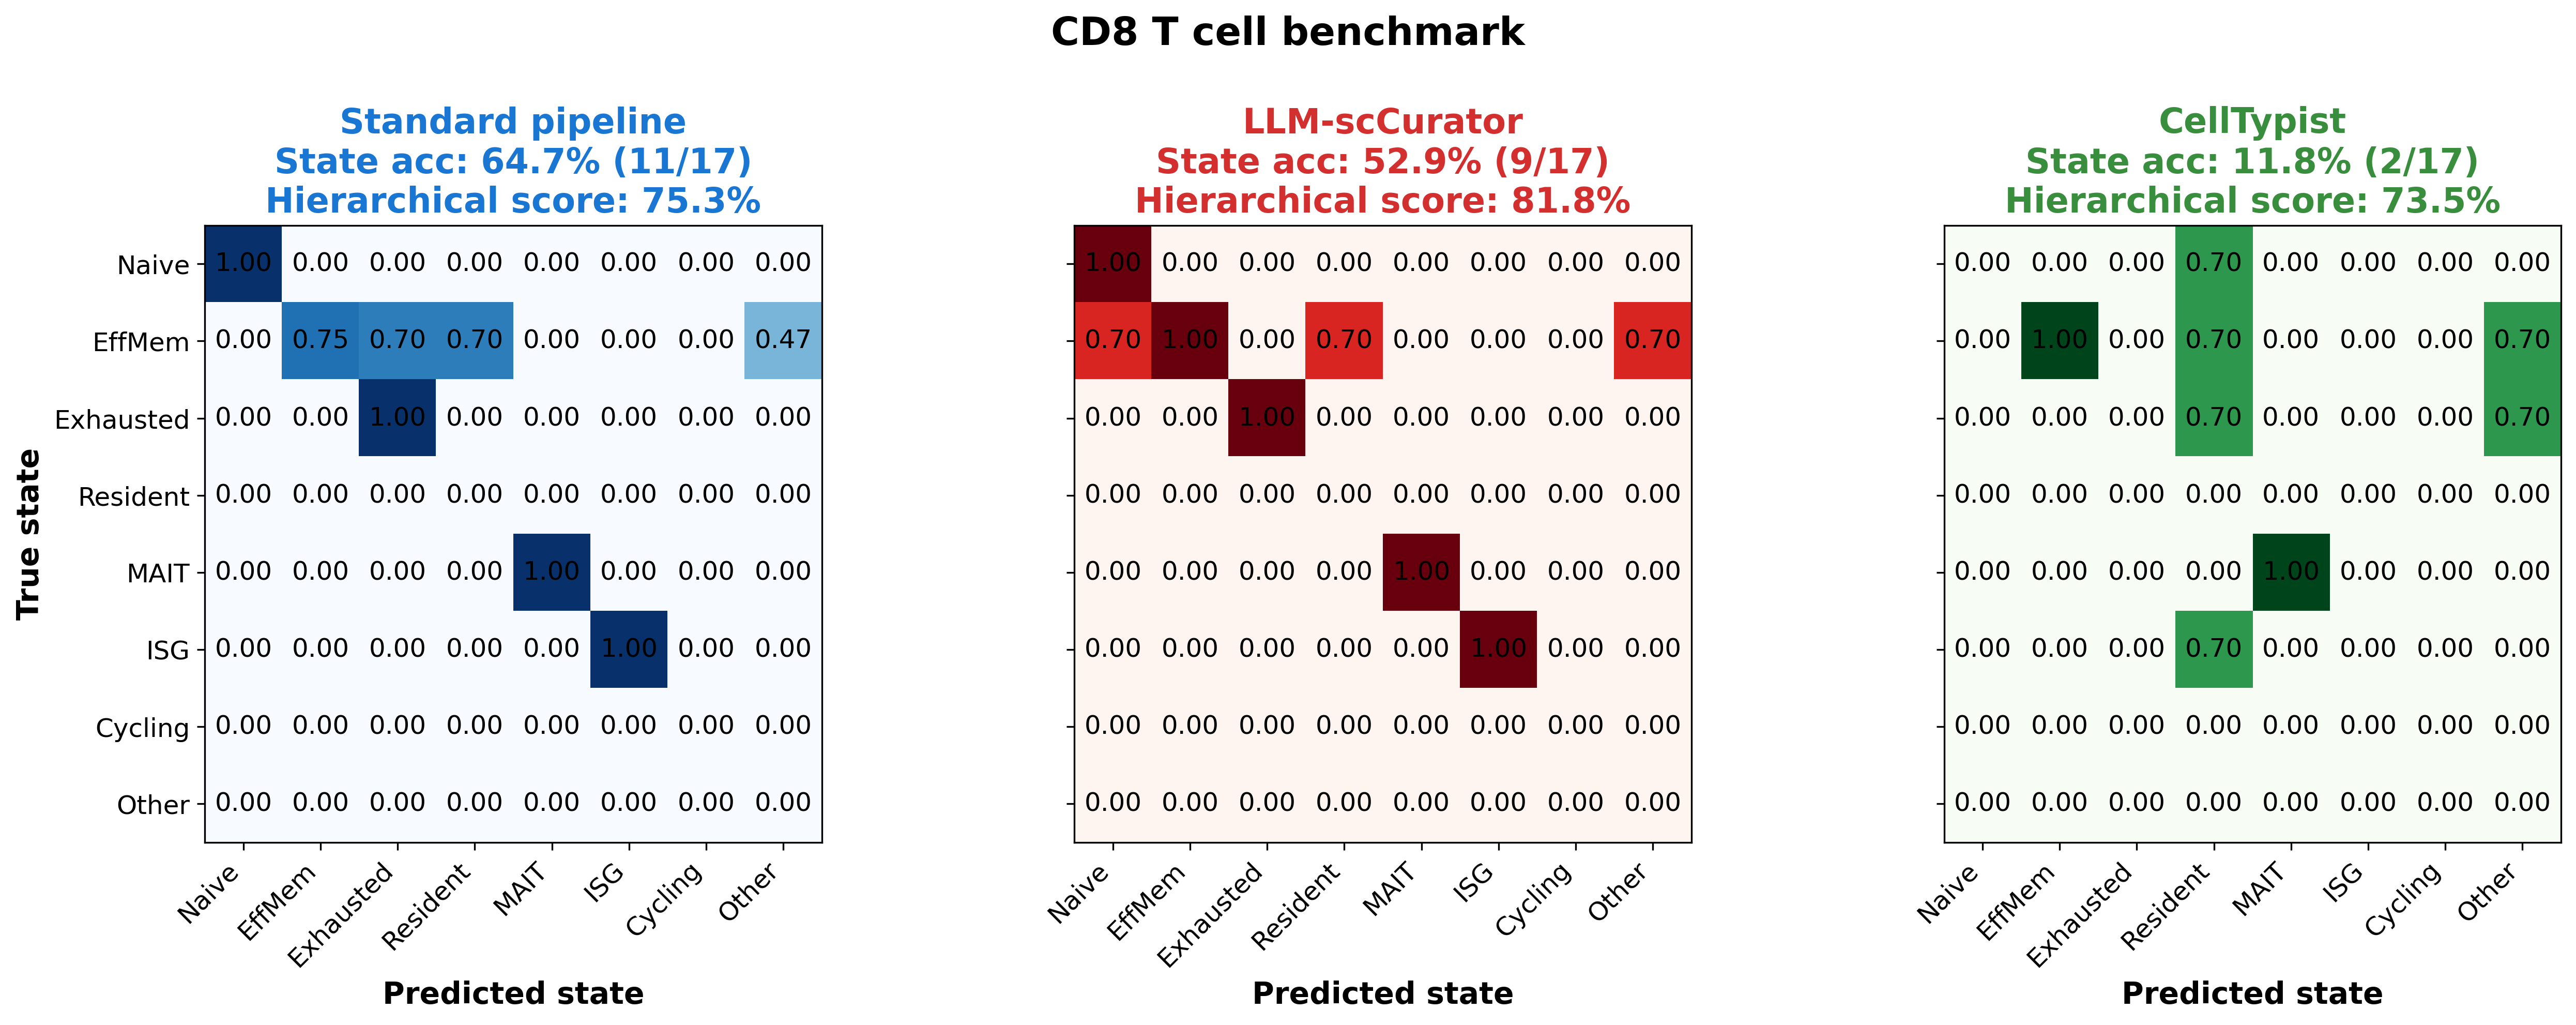

[INFO] Saved CD8 T cell confusion figure → /runs/20251201.v1/ED_Fig2a_CD8_Confusion_Standard_Curated_CellTypist.pdf


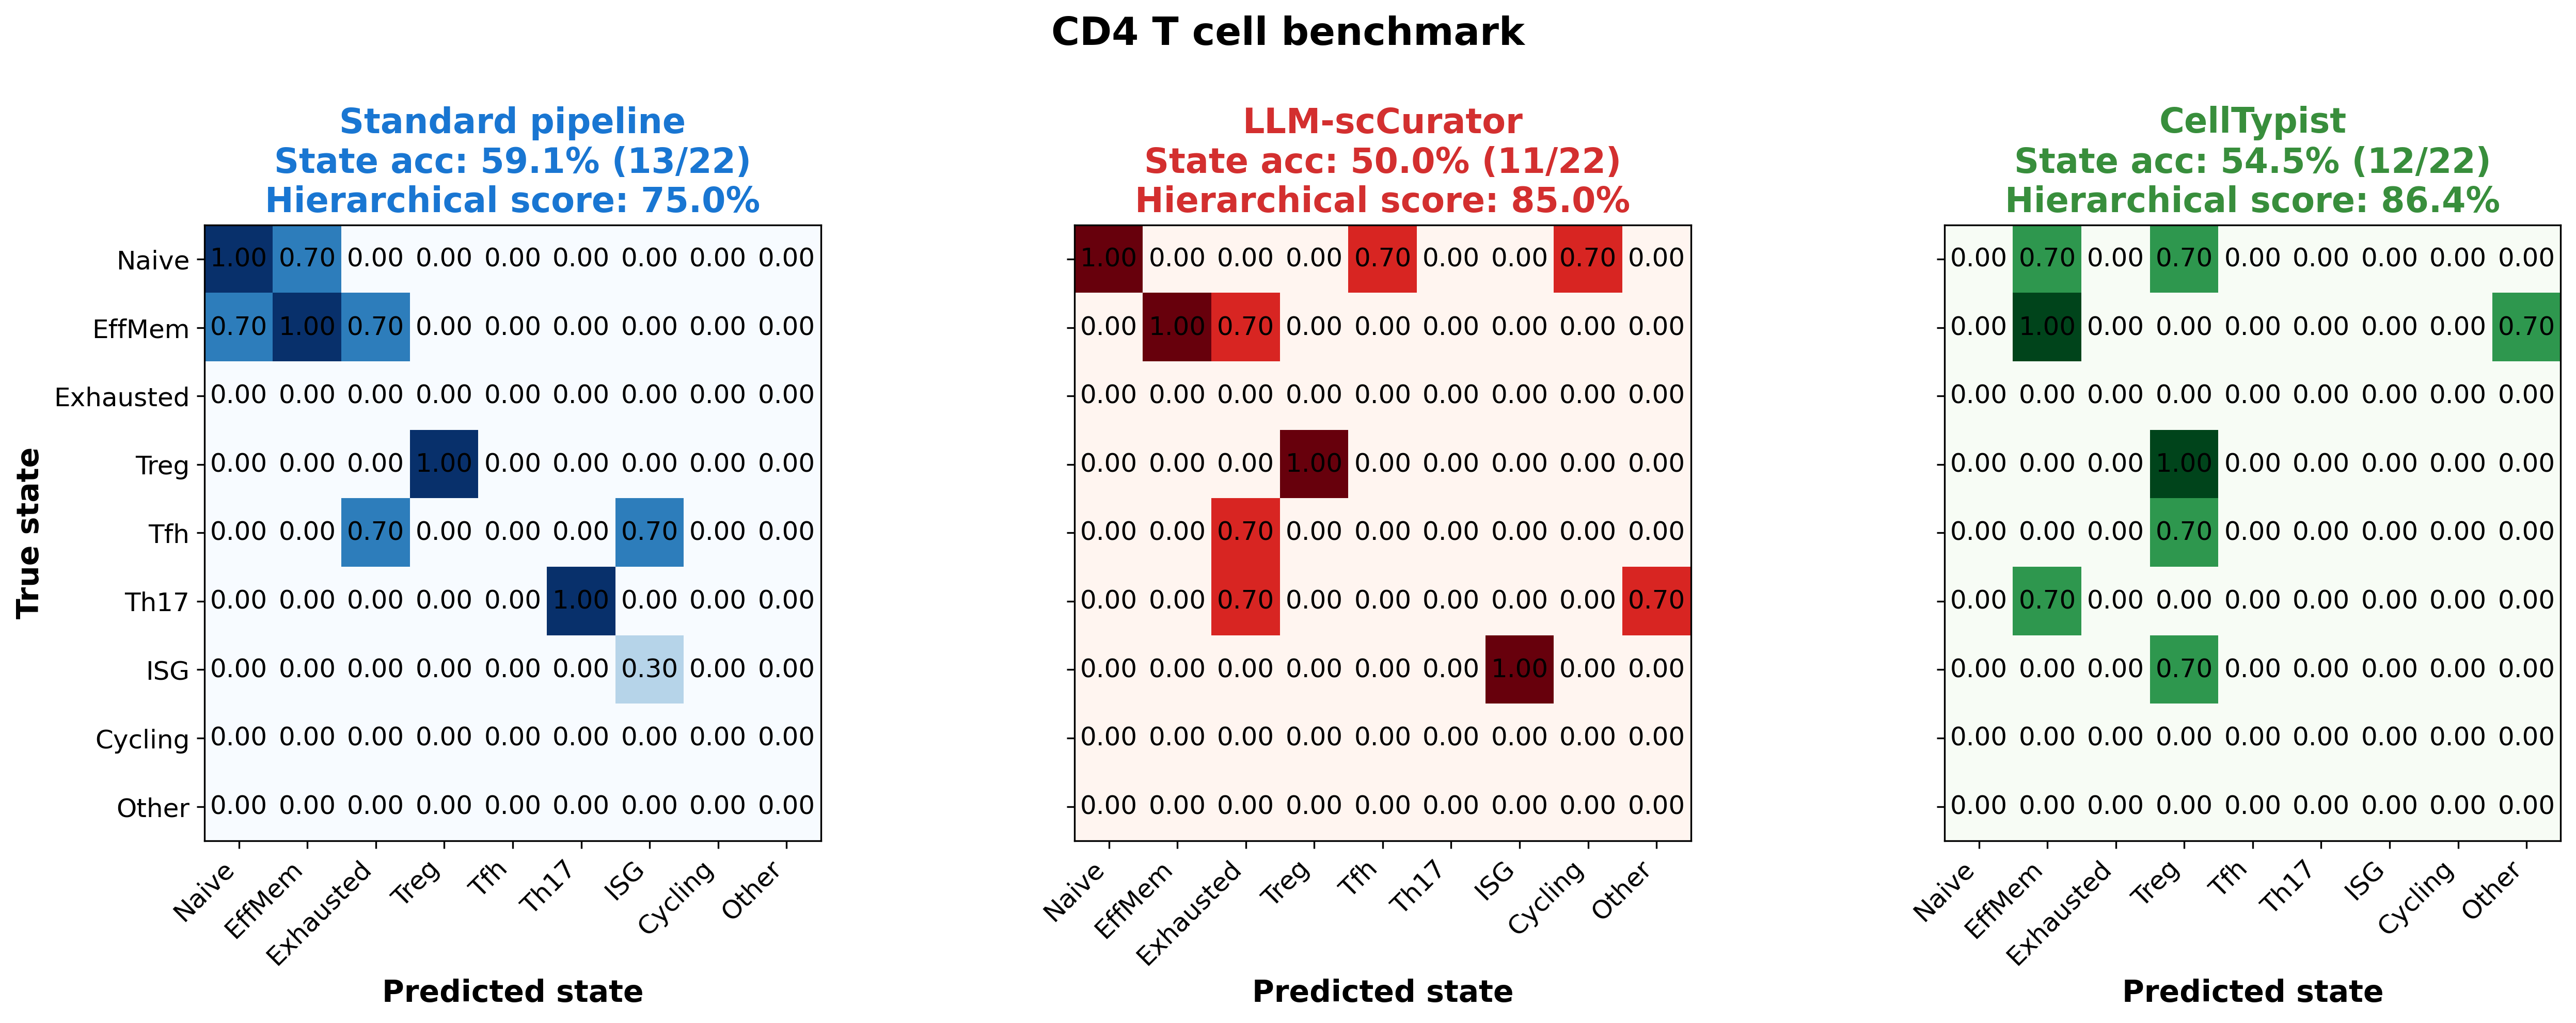

[INFO] Saved CD4 T cell confusion figure → /runs/20251201.v1/ED_Fig2b_CD4_Confusion_Standard_Curated_CellTypist.pdf


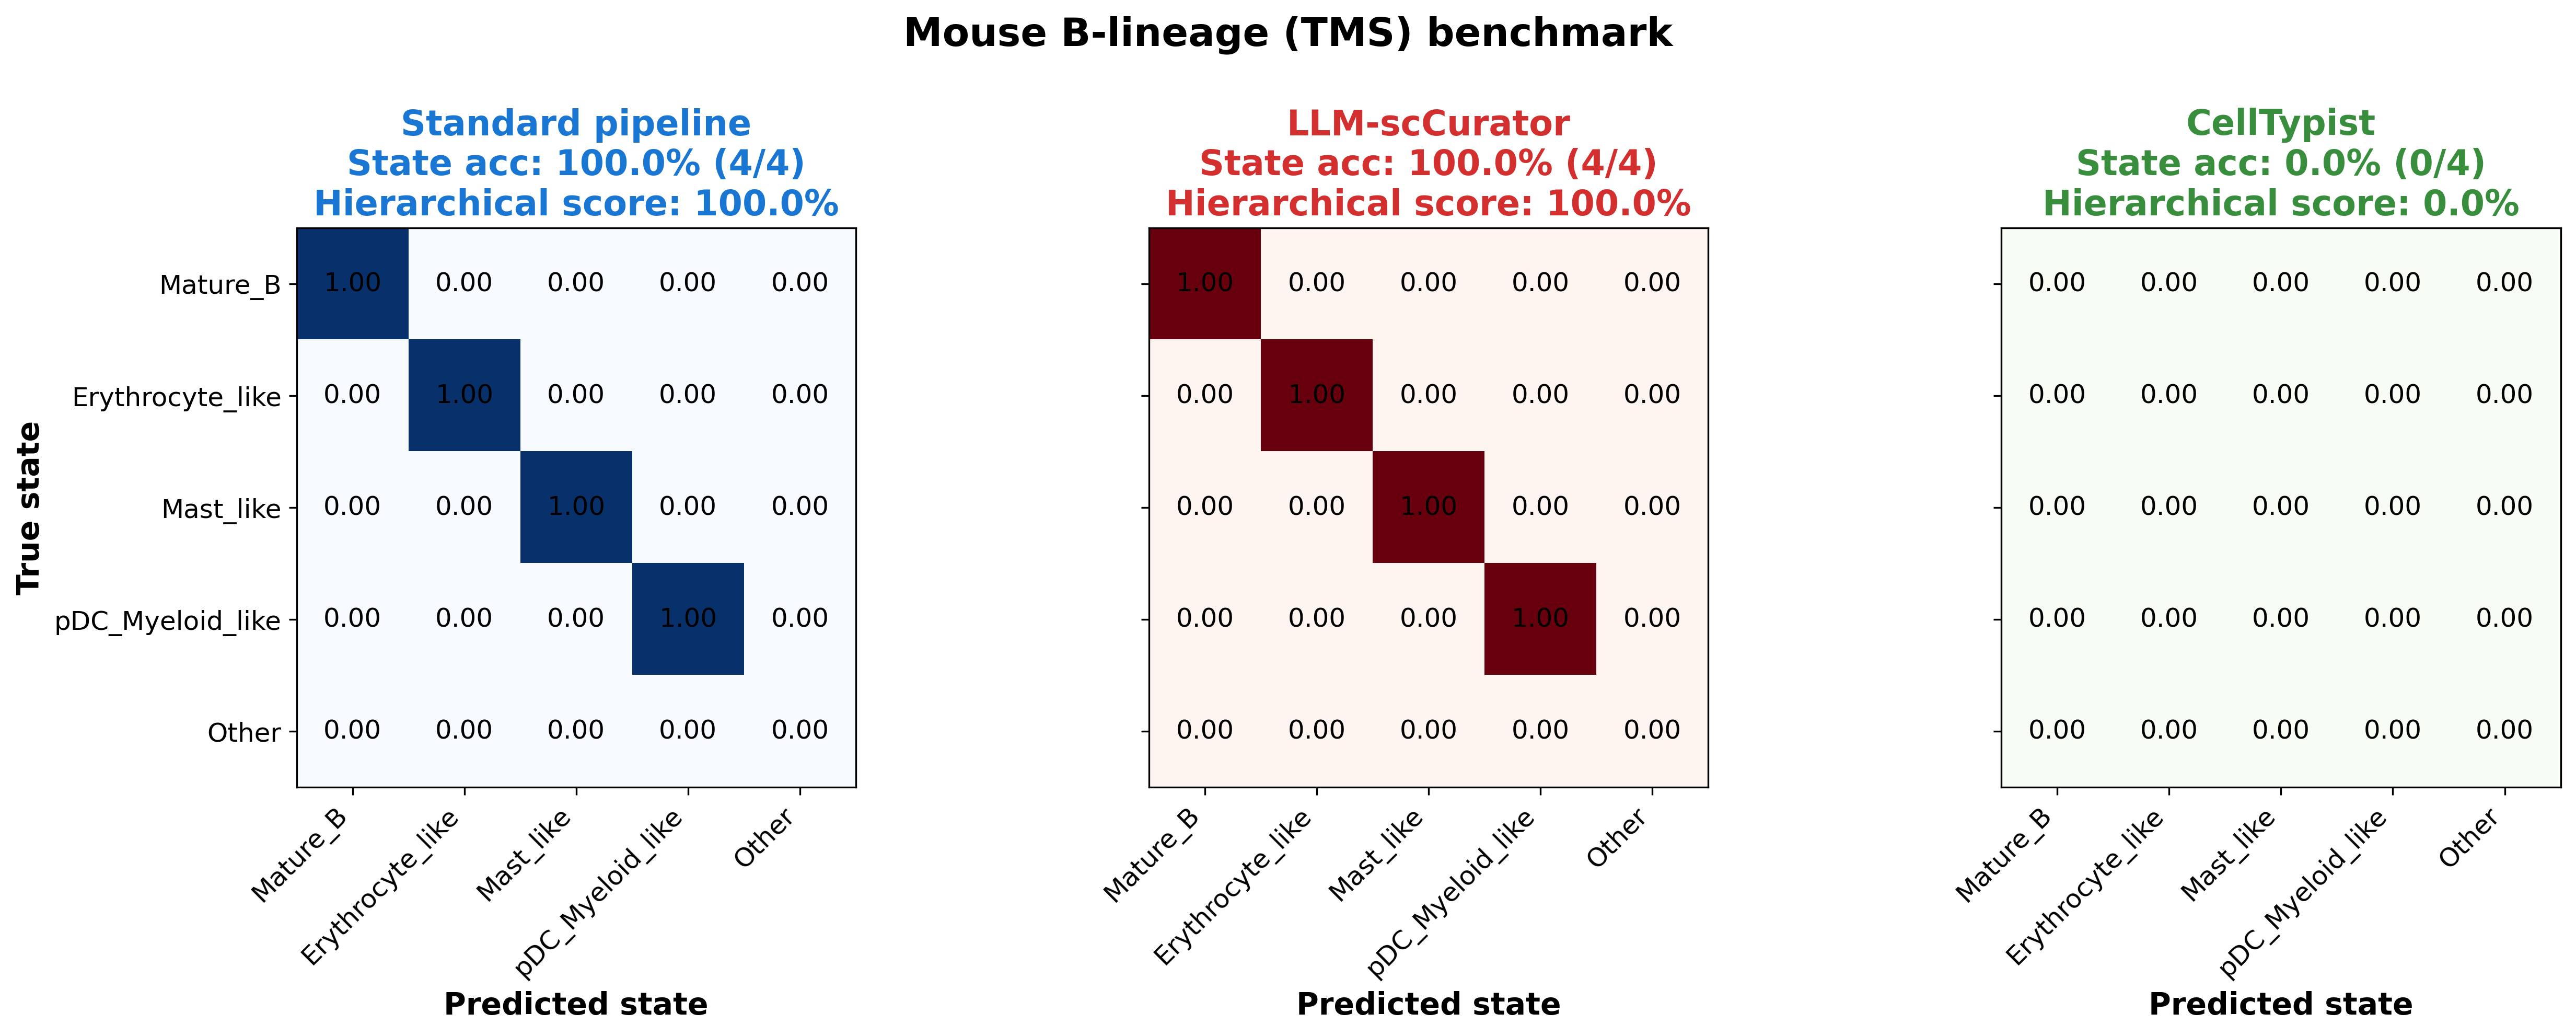

[INFO] Saved Mouse B-lineage (TMS) confusion figure → /runs/20251201.v1/MOUSEB_Confusion_Standard_Curated_CellTypist.pdf


In [ ]:
# ============================================================
# For Extended Data: Confusion Matrix for CD8 / CD4 / MOUSE_B
# ============================================================

from benchmarks.hierarchical_scoring import _parse_state_generic
from benchmarks.cd8_config import CD8_HIER_CFG
from benchmarks.cd4_config import CD4_HIER_CFG
from benchmarks.mouse_b_config import MOUSE_B_CFG

CD8_SCORED     = os.path.join(OUT_DIR, "cd8_benchmark_results_integrated_SCORED.csv")
CD4_SCORED     = os.path.join(OUT_DIR, "cd4_benchmark_results_integrated_SCORED.csv")
MOUSE_B_SCORED = os.path.join(OUT_DIR, "mouse_b_benchmark_results_integrated_SCORED.csv")


def compute_confusion_generic(
    df: pd.DataFrame,
    cfg,
    pipeline: str,
    state_order: list,
) -> dict:
    """

    - df: *_SCORED.csv を読み込んだ DataFrame
    - cfg: CD8_HIER_CFG / CD4_HIER_CFG / MOUSE_B_CFG
    - pipeline: "Standard" / "Curated" / "CellTypist"
    - state_order: List for determining the order of axes (fixed)

    Return value:
        {
          "labels": state_order,
          "cm_norm": (n_state x n_state 行列；セル内は平均 hierarchical score 0–1),
          "state_acc": float,
          "n_correct": int,
          "n": int,
          "hier_mean": float
        }
    """
    pred_col = choose_prediction_column(df, pipeline)
    score_col = f"Score_{pipeline}"
    if score_col not in df.columns:
        raise ValueError(f"{score_col} not found in dataframe.")

    if "UsedInConfusion" in df.columns:
        df_used = df[df["UsedInConfusion"]].copy()
    else:
        df_used = df[df["GT_State"] != cfg.default_state].copy()

    gt_states = []
    pred_states = []

    # Axis labels are unified in fixed order (state_order)
    labels = state_order[:]
    label_to_idx = {lab: i for i, lab in enumerate(labels)}

    # cm_sum: Sum of scores, cm_count: Number of entries in the cell
    cm_sum = np.zeros((len(labels), len(labels)), dtype=float)
    cm_count = np.zeros((len(labels), len(labels)), dtype=int)

    for _, row in df_used.iterrows():
        gt = str(row["GT_State"])
        pred = _parse_state_generic(str(row[pred_col]), cfg)
        score = float(row[score_col])

        gt_lab = gt if gt in label_to_idx else "Other"
        pred_lab = pred if pred in label_to_idx else "Other"

        i = label_to_idx[gt_lab]
        j = label_to_idx[pred_lab]

        cm_sum[i, j] += score
        cm_count[i, j] += 1

        gt_states.append(gt_lab)
        pred_states.append(pred_lab)

    # Average hierarchical score (0–1) for each cell
    with np.errstate(invalid="ignore", divide="ignore"):
        cm_mean = np.where(cm_count > 0, cm_sum / cm_count, 0.0)

    # State Accuracy Rate (Whether it is an exact match)
    n = len(gt_states)
    n_correct = sum(1 for g, p in zip(gt_states, pred_states) if g == p)
    state_acc = 100.0 * n_correct / n if n > 0 else 0.0

    Overall average of hierarchical scores (%)
    hier_mean = df_used[score_col].dropna().astype(float).mean() * 100.0

    return {
        "labels": labels,
        "cm_norm": cm_mean,
        "state_acc": state_acc,
        "n_correct": n_correct,
        "n": n,
        "hier_mean": hier_mean,
    }


def plot_confusion_generic(
    scored_csv: str,
    cfg,
    state_order: list,
    dataset_name: str,
    out_pdf: str,
    out_png: str = None,
):
    """
    Create an Extended Data figure for each dataset_name.
    Panels are Standard / LLM-scCurator / CellTypist.
    Each cell shows the average hierarchical score (0–1) for (GT_state, Pred_state).
    """
    df = pd.read_csv(scored_csv)

    pipelines = ["Standard", "Curated", "CellTypist"]
    titles = {
        "Standard":   "Standard pipeline",
        "Curated":    "LLM-scCurator",
        "CellTypist": "CellTypist",
    }

    results = {
        p: compute_confusion_generic(df, cfg, p, state_order)
        for p in pipelines
    }

    fig, axes = plt.subplots(
        1, len(pipelines),
        figsize=(6 * len(pipelines), 6),
        dpi=300
    )

    if len(pipelines) == 1:
        axes = [axes]

    for ax, pipeline in zip(axes, pipelines):
        res = results[pipeline]
        labels = res["labels"]
        cm = res["cm_norm"]  # mean hierarchical score (0–1)

        im = ax.imshow(
            cm,
            vmin=0.0,
            vmax=1.0,
            cmap=PIPELINE_CMAPS[pipeline],
        )

        ax.set_xticks(np.arange(len(labels)))
        ax.set_yticks(np.arange(len(labels)))
        ax.set_xticklabels(labels, rotation=45, ha="right", fontsize=12)
        ax.set_yticklabels(labels, fontsize=12)

        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                val = cm[i, j]
                ax.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=12)

        title = (
            f"{titles[pipeline]}\n"
            f"State acc: {res['state_acc']:.1f}% "
            f"({res['n_correct']}/{res['n']})\n"
            f"Hierarchical score: {res['hier_mean']:.1f}%"
        )
        ax.set_title(
            title,
            fontsize=16,
            fontweight="bold",
            color=PIPELINE_TITLE_COLORS[pipeline],
        )

        if ax is axes[0]:
            ax.set_ylabel("True state", fontsize=14, fontweight="bold")
        else:
            ax.set_yticklabels([])

        ax.set_xlabel("Predicted state", fontsize=14, fontweight="bold")

    plt.suptitle(
        f"{dataset_name} benchmark",
        fontsize=18,
        fontweight="bold",
        y=1.05,
    )
    plt.tight_layout()
    plt.savefig(out_pdf, bbox_inches="tight")
    if out_png is not None:
        plt.savefig(out_png, dpi=300, bbox_inches="tight")
    plt.show()

    print(f"[INFO] Saved {dataset_name} confusion figure → {out_pdf}")


# ------------------------------------------------------------
#  Output Extended Data plots for CD8, CD4, and MOUSE_B
# ------------------------------------------------------------

# CD8: T cell subset
cd8_state_order = [
    "Naive",
    "EffMem",
    "Exhausted",
    "Resident",
    "MAIT",
    "ISG",
    "Cycling",
    "Other",
]

cd8_conf_pdf = os.path.join(OUT_DIR, "ED_Fi2a_CD8_Confusion_Standard_Curated_CellTypist.pdf")
cd8_conf_png = os.path.join(OUT_DIR, "ED_Fi2a_CD8_Confusion_Standard_Curated_CellTypist.png")

plot_confusion_generic(
    scored_csv=CD8_SCORED,
    cfg=CD8_HIER_CFG,
    state_order=cd8_state_order,
    dataset_name="CD8 T cell",
    out_pdf=cd8_conf_pdf,
    out_png=cd8_conf_png,
)


# CD4: CD4+ T cell subset
cd4_state_order = [
    "Naive",
    "EffMem",
    "Exhausted",
    "Treg",
    "Tfh",
    "Th17",
    "ISG",
    "Cycling",
    "Other",
]

cd4_conf_pdf = os.path.join(OUT_DIR, "ED_Fi2b_CD4_Confusion_Standard_Curated_CellTypist.pdf")
cd4_conf_png = os.path.join(OUT_DIR, "ED_Fi2b_CD4_Confusion_Standard_Curated_CellTypist.png")

plot_confusion_generic(
    scored_csv=CD4_SCORED,
    cfg=CD4_HIER_CFG,
    state_order=cd4_state_order,
    dataset_name="CD4 T cell",
    out_pdf=cd4_conf_pdf,
    out_png=cd4_conf_png,
)


# MOUSE_B: Tabula Muris Senis B-lineage contamination benchmark
mouse_b_state_order = [
    "Mature_B",
    "Erythrocyte_like",
    "Mast_like",
    "pDC_Myeloid_like",
    "Other",
]

mouse_b_conf_pdf = os.path.join(OUT_DIR, "MOUSEB_Confusion_Standard_Curated_CellTypist.pdf")
mouse_b_conf_png = os.path.join(OUT_DIR, "MOUSEB_Confusion_Standard_Curated_CellTypist.png")

plot_confusion_generic(
    scored_csv=MOUSE_B_SCORED,
    cfg=MOUSE_B_CFG,
    state_order=mouse_b_state_order,
    dataset_name="Mouse B-lineage (TMS)",
    out_pdf=mouse_b_conf_pdf,
    out_png=mouse_b_conf_png,
)
